# Image Impeccable Challenge: Journey to Clarity

## Part 1 : Data Exploration, Analysis, and Preparation

By: Leo Dinendra

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import os
import pprint as pp
from PIL import Image
from tqdm import tqdm
from skimage.metrics import structural_similarity as sk_ssim
from utils import *

### 0. General Setting

Put the location of training dataset folder below.

In [2]:
raw_data_path = './image-impeccable-train-data'
output_data_path =  './training_data_processed'

In [3]:
if not os.path.exists(output_data_path):
    os.makedirs(output_data_path)

### 1. Data Exploration & Analysis

List all training data.

In [4]:
seis_files = []
noise_files = []
for root, dirs, files in os.walk(raw_data_path):
    for file in files:
        if file.lower().endswith('.npy') and '_RFC_' in file:
            full_path = os.path.join(root, file)
            seis_files.append(full_path)
        elif file.lower().endswith('.npy') and 'seismic_w_noise' in file:
            full_path = os.path.join(root, file)
            noise_files.append(full_path)

In [5]:
print("there are", len(seis_files), "pair of files.")

there are 243 pair of files.


List bad data with non-match seismic and label for us to avoid.

In [6]:
bad_data = ['42673698', '77692226', '77692237', '77692243', '77692246', '77702634', 
            '77702638', '89194322', '89194324']

In [7]:
seis_files = [filename for filename in seis_files if not any(bad_str in filename for bad_str in bad_data)]
noise_files = [filename for filename in noise_files if not any(bad_str in filename for bad_str in bad_data)]

In [8]:
print("there are", len(seis_files), "pair of files after removing the bad data.")

there are 234 pair of files after removing the bad data.


Function to rearrange axis of seismic that have different shape.

In [9]:
def check_and_swap_axes(arr):
    target_shape = (1259, 300, 300)
    
    if arr.shape == target_shape:
        return arr

    permuted = np.transpose(arr, axes=(2,1,0))
    if permuted.shape == target_shape:
        return permuted
    
    # raise an error if data not match any standart shape
    raise ValueError(f"Cannot reshape or permute array to shape {target_shape}. Current shape: {arr.shape}")

Load sample data to analyze.

In [10]:
no_file = 1
seismic = np.load(seis_files[no_file], allow_pickle=True, mmap_mode="r+")
noise = np.load(noise_files[no_file], allow_pickle=True, mmap_mode="r+")
seismic = check_and_swap_axes(seismic)
noise = check_and_swap_axes(noise)
print(f"Seismic data shape: {seismic.shape}")
print(f"Noisy data shape: {noise.shape}")

Seismic data shape: (1259, 300, 300)
Noisy data shape: (1259, 300, 300)


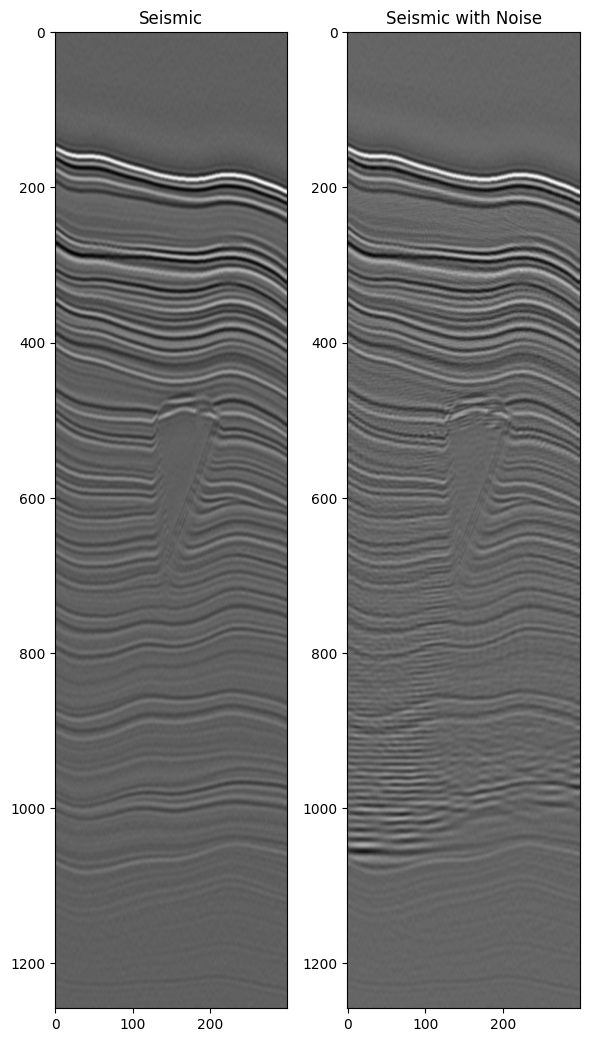

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(6, 12))
ax[0].imshow(seismic[:, 200, :], cmap="gray")
ax[0].set_title("Seismic")
ax[1].imshow(noise[:, 200, :], cmap="gray")
ax[1].set_title("Seismic with Noise")
plt.tight_layout()
plt.show()

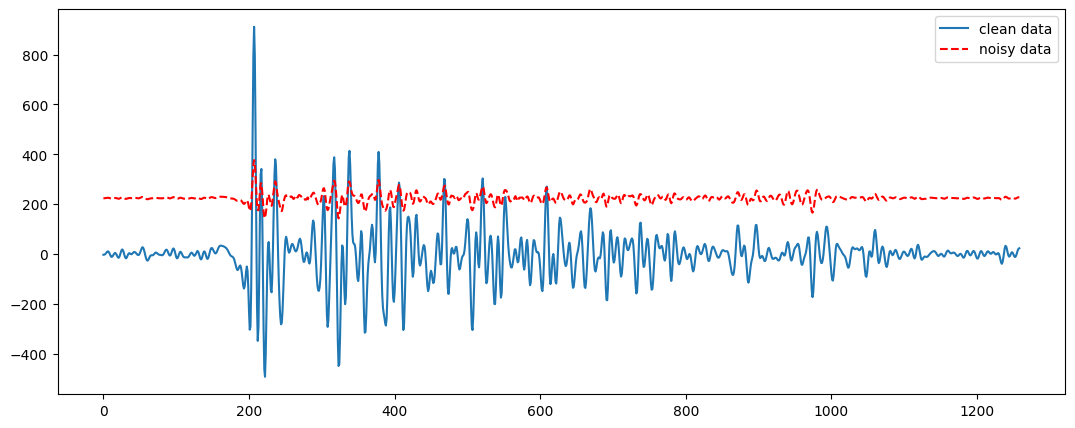

In [12]:
plt.figure(figsize=(13,5))
plt.plot(seismic[:, 200, -1])
plt.plot(noise[:, 200, -1], '--r')
plt.legend(['clean data','noisy data'])
plt.show()

In theory, raw seismic data consists of cleaned data plus noise. However, as we can see, the variance and mean of the data do not match. Therefore, we need to normalize the data first. 

Simply normalizing the data using a standard min-max scaling approach may not work, as we cannot be sure whether the maximum or minimum values are affected by noise. That's why we will scale the data using anchor values from the water column area that is unaffected by noise, say, around 50 grid points from the surface, then use that to rescale the data.

In [13]:
seis2d = seismic[:,200,:]
noise2d = noise[:,200,:]

seis_min = np.min(seis2d)
seis_max = np.max(seis2d)
seis2d = (seis2d - seis_min) / (seis_max - seis_min)
mean_seis = np.mean(seis2d)
seis2d = seis2d - mean_seis
seis_normalize = np.max([np.max(seis2d), np.abs(np.min(seis2d))])
seis2d = seis2d * (0.5/seis_normalize)

noise_min = np.min(noise2d)
noise_max = np.max(noise2d)
noise2d = (noise2d - noise_min) / (noise_max - noise_min)
mean_noise = np.mean(noise2d)
noise2d = noise2d - mean_noise
noise_normalize = np.max([np.max(noise2d), np.abs(np.min(noise2d))])
noise2d = noise2d * (0.5/noise_normalize)

scale = np.max(seis2d[:50,:])/np.max(noise2d[:50,:])
seis2d=seis2d/scale

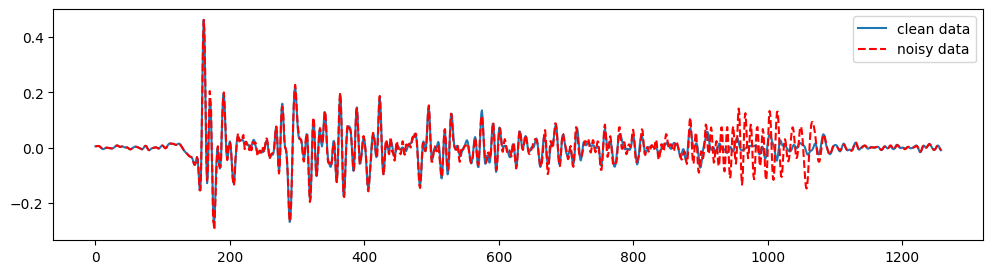

In [14]:
plt.figure(figsize=(12,3))
plt.plot(seis2d[:, 50])
plt.plot(noise2d[:, 50], '--r')
plt.legend(['clean data','noisy data'])
plt.show()

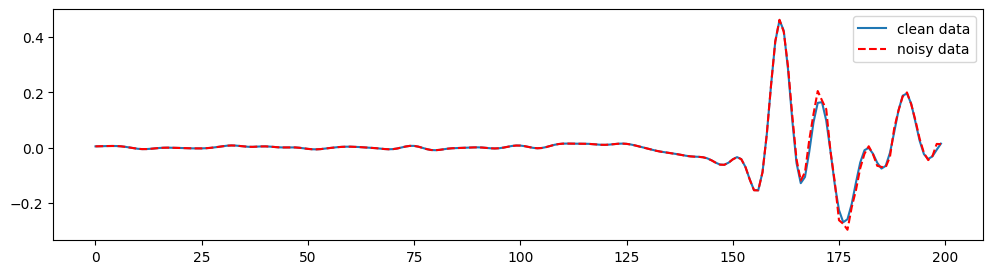

In [15]:
plt.figure(figsize=(12,3))
plt.plot(seis2d[:200, 50])
plt.plot(noise2d[:200, 50], '--r')
plt.legend(['clean data','noisy data'])
plt.show()

Here are the result.

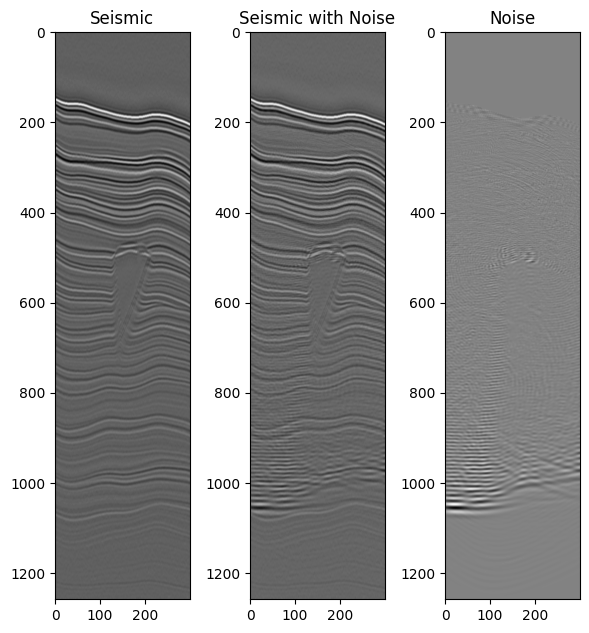

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(6, 12))
ax[0].imshow(seis2d, cmap="gray")
ax[0].set_title("Seismic")
ax[1].imshow(noise2d, cmap="gray")
ax[1].set_title("Seismic with Noise")
ax[2].imshow(noise2d-seis2d, cmap="gray")
ax[2].set_title("Noise")
plt.tight_layout()
plt.show()

Great. With this, we hope to reduce the complexity of the solution that the model needs to learn. Now, we will focus on finding a method to overcome the noise.

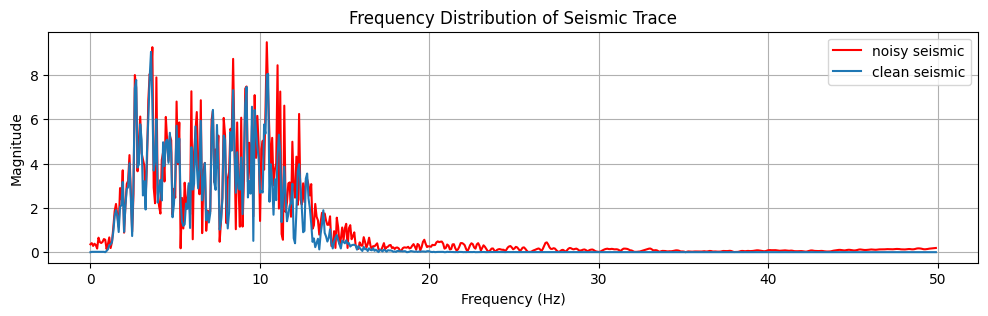

In [17]:
fft_result1 = np.fft.fft(seis2d[:, 50])
frequencies1 = np.fft.fftfreq(len(seis2d[:, 50]), d=1e-2) #we just assume the sampling rate here
magnitude1 = np.abs(fft_result1)
positive_frequencies1 = frequencies1[:len(frequencies1)//2]
positive_magnitude1 = magnitude1[:len(magnitude1)//2]

fft_result2 = np.fft.fft(noise2d[:, 50])
frequencies2 = np.fft.fftfreq(len(noise2d[:, 50]), d=1e-2)
magnitude2 = np.abs(fft_result2)
positive_frequencies2 = frequencies2[:len(frequencies2)//2]
positive_magnitude2 = magnitude2[:len(magnitude2)//2]

plt.figure(figsize=(12, 3))
plt.plot(positive_frequencies2, positive_magnitude2, '-r')
plt.plot(positive_frequencies1, positive_magnitude1)
plt.legend(['noisy seismic', 'clean seismic'])
plt.title('Frequency Distribution of Seismic Trace')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()

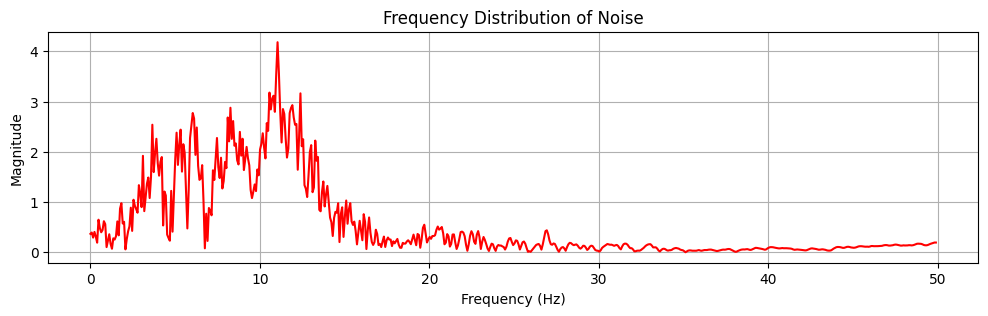

In [18]:
fft_result1 = np.fft.fft(noise2d[:, 50]- seis2d[:, 50])
frequencies1 = np.fft.fftfreq(len(seis2d[:, 50]), d=1e-2)
magnitude1 = np.abs(fft_result1)
positive_frequencies1 = frequencies1[:len(frequencies1)//2]
positive_magnitude1 = magnitude1[:len(magnitude1)//2]
plt.figure(figsize=(12, 3))
plt.plot(positive_frequencies1, positive_magnitude1, '-r')
plt.title('Frequency Distribution of Noise')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()

From the image and frequency plot, it seems there are two types of noise we will encounter: random noise at higher frequencies and coherent noise in the low to medium frequency range, which also overlaps with the range of our clean seismic data.

For noisy data, similar to conventional seismic processing, we can reduce noise by stacking the seismic data to improve the signal-to-noise ratio. Since we are using a 2D slice approach for prediction, we will generate four different cube results, which we will then stack into a single final cube.

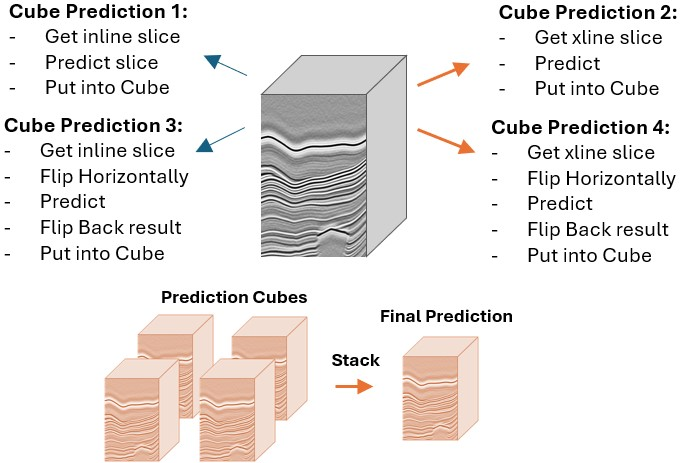

Now this leaves the coherent noise for the model training to figure out.

---

### 2. Preprocess Data for Training Phase

Process the entire training dataset using the approach mentioned above before feeding it into our model. We don't need to use every single slice; a spacing of 10 inline/xline slices and diagonal lines are sufficient. Data augmentation will be applied later in the training pipeline.

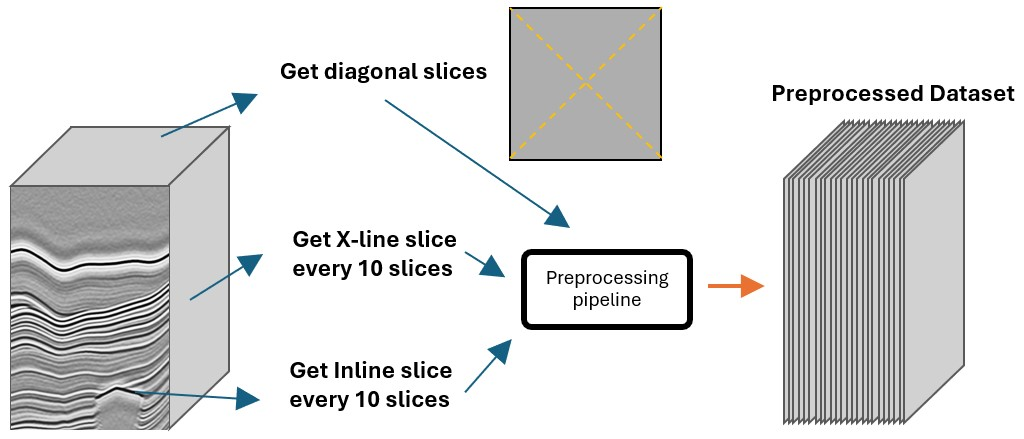

In [19]:
for i in tqdm(range(len(seis_files))):
    seismic = np.load(seis_files[i], allow_pickle=True, mmap_mode="r+").astype('float32')
    noise = np.load(noise_files[i], allow_pickle=True, mmap_mode="r+").astype('float32')

    # Check if the array already has the correct shape
    target_shape = (1259, 300, 300)
    if seismic.shape != target_shape:
        seismic = np.transpose(seismic, axes=(2,1,0))
    if noise.shape != target_shape:
        noise = np.transpose(noise, axes=(2,1,0))
        
    slice_id = np.arange(0,299,10).tolist()

    for j in slice_id:
        
        #GET XLINE SLICE
        seis2d = seismic[:,:,j]
        noise2d = noise[:,:,j]

        # normalize data between 0 and 1
        seis_min = np.min(seis2d)
        seis_max = np.max(seis2d)
        seis2d = (seis2d - seis_min) / (seis_max - seis_min)

        noise_min = np.min(noise2d)
        noise_max = np.max(noise2d)
        noise2d = (noise2d - noise_min) / (noise_max - noise_min)
        
        # mean center
        mean_seis = np.mean(seis2d)
        seis2d = seis2d - mean_seis
        seis_normalize = np.max([np.max(seis2d), np.abs(np.min(seis2d))])
        seis2d = seis2d * (0.5/seis_normalize)
        mean_noise = np.mean(noise2d)
        noise2d = noise2d - mean_noise
        noise_normalize = np.max([np.max(noise2d), np.abs(np.min(noise2d))])
        noise2d = noise2d * (0.5/noise_normalize)
        
        # rescale
        scale = np.max(seis2d[:50,:])/np.max(noise2d[:50,:])
        seis2d=seis2d/scale
        
        #change mean to 0.5 because ssim only takes minimum input of 0 (non-negative).
        seis2d = seis2d + 0.5
        noise2d = noise2d + 0.5

        np.save(output_data_path +'/seismic_' + seis_files[i].split('/')[1].split('\\')[2]+'_x_'+'%03d' % j+'.npy', 
                    seis2d)
        np.save(output_data_path +'/noise_' + seis_files[i].split('/')[1].split('\\')[2]+'_x_'+'%03d' % j+'.npy', 
                    noise2d)    
        
        # GET INLINE SLICE
        seis2d = seismic[:,j,:]
        noise2d = noise[:,j,:]

        # normalize data between 0 and 1
        seis_min = np.min(seis2d)
        seis_max = np.max(seis2d)
        seis2d = (seis2d - seis_min) / (seis_max - seis_min)

        noise_min = np.min(noise2d)
        noise_max = np.max(noise2d)
        noise2d = (noise2d - noise_min) / (noise_max - noise_min)
        
        # mean center
        mean_seis = np.mean(seis2d)
        seis2d = seis2d - mean_seis
        seis_normalize = np.max([np.max(seis2d), np.abs(np.min(seis2d))])
        seis2d = seis2d * (0.5/seis_normalize)
        mean_noise = np.mean(noise2d)
        noise2d = noise2d - mean_noise
        noise_normalize = np.max([np.max(noise2d), np.abs(np.min(noise2d))])
        noise2d = noise2d * (0.5/noise_normalize)
        
        # rescale
        scale = np.max(seis2d[:50,:])/np.max(noise2d[:50,:])
        seis2d=seis2d/scale
        
        #change mean to 0.5 because ssim only takes minimum input of 0 (non-negative).
        seis2d = seis2d + 0.5
        noise2d = noise2d + 0.5

        np.save(output_data_path +'/seismic_'+ seis_files[i].split('/')[1].split('\\')[2]+'_i_'+'%03d' % j+'.npy', 
                    seis2d)
        np.save(output_data_path +'/noise_'+ seis_files[i].split('/')[1].split('\\')[2]+'_i_'+'%03d' % j+'.npy', 
                    noise2d) 

    #GET DIAGONAL SLICE 1
    seis2d = np.array([seismic[:, k, 299-k] for k in range(300)]).T
    noise2d = np.array([noise[:, k, 299-k] for k in range(300)]).T

    # normalize data between 0 and 1
    seis_min = np.min(seis2d)
    seis_max = np.max(seis2d)
    seis2d = (seis2d - seis_min) / (seis_max - seis_min)

    noise_min = np.min(noise2d)
    noise_max = np.max(noise2d)
    noise2d = (noise2d - noise_min) / (noise_max - noise_min)

    # mean center
    mean_seis = np.mean(seis2d)
    seis2d = seis2d - mean_seis
    seis_normalize = np.max([np.max(seis2d), np.abs(np.min(seis2d))])
    seis2d = seis2d * (0.5/seis_normalize)
    mean_noise = np.mean(noise2d)
    noise2d = noise2d - mean_noise
    noise_normalize = np.max([np.max(noise2d), np.abs(np.min(noise2d))])
    noise2d = noise2d * (0.5/noise_normalize)

    # rescale
    scale = np.max(seis2d[:50,:])/np.max(noise2d[:50,:])
    seis2d=seis2d/scale

    #change mean to 0.5 because ssim only takes minimum input of 0 (non-negative).
    seis2d = seis2d + 0.5
    noise2d = noise2d + 0.5

    np.save(output_data_path +'/seismic_'+ seis_files[i].split('/')[1].split('\\')[2]+'_diag1_'+'.npy', 
                seis2d)
    np.save(output_data_path +'/noise_'+ seis_files[i].split('/')[1].split('\\')[2]+'_diag1_'+'.npy',  
                noise2d)         

    #GET DIAGONAL SLICE 2
    seis2d = np.array([seismic[:, k, k] for k in range(300)]).T
    noise2d = np.array([noise[:, k, k] for k in range(300)]).T

    # normalize data between 0 and 1
    seis_min = np.min(seis2d)
    seis_max = np.max(seis2d)
    seis2d = (seis2d - seis_min) / (seis_max - seis_min)

    noise_min = np.min(noise2d)
    noise_max = np.max(noise2d)
    noise2d = (noise2d - noise_min) / (noise_max - noise_min)

    # mean center
    mean_seis = np.mean(seis2d)
    seis2d = seis2d - mean_seis
    seis_normalize = np.max([np.max(seis2d), np.abs(np.min(seis2d))])
    seis2d = seis2d * (0.5/seis_normalize)
    mean_noise = np.mean(noise2d)
    noise2d = noise2d - mean_noise
    noise_normalize = np.max([np.max(noise2d), np.abs(np.min(noise2d))])
    noise2d = noise2d * (0.5/noise_normalize)

    # rescale
    scale = np.max(seis2d[:50,:])/np.max(noise2d[:50,:])
    seis2d=seis2d/scale

    #change mean to 0.5 because ssim only takes minimum input of 0 (non-negative).
    seis2d = seis2d + 0.5
    noise2d = noise2d + 0.5

    np.save(output_data_path +'/seismic_'+ seis_files[i].split('/')[1].split('\\')[2]+'_diag2_'+'.npy', 
                seis2d)
    np.save(output_data_path +'/noise_'+ seis_files[i].split('/')[1].split('\\')[2]+'_diag2_'+'.npy',  
                noise2d) 



100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [21:29<00:00,  5.51s/it]


Training dataset prepared, now move to training phase.

---

This notebook is licensed under the [MIT License](./LICENSE).